In [1]:
# Shuo Test config files
import time, os, quaternion, habitat_sim
os.chdir("/home/ubuntu/sound-space/sound-spaces")

backend_cfg = habitat_sim.SimulatorConfiguration()
backend_cfg.scene_id = "data/scene_datasets/gibson/Oyens.glb"
backend_cfg.scene_dataset_config_file = "data/scene_datasets/gibson/gibson_semantic.scene_dataset_config.json"
backend_cfg.load_semantic_mesh = True
backend_cfg.enable_physics = False

t=time.time()
agent_config = habitat_sim.AgentConfiguration()
print("agent ok", time.time()-t, flush=True)

t=time.time()
cfg = habitat_sim.Configuration(backend_cfg, [agent_config])
print("cfg ok", time.time()-t, flush=True)


C
agent ok 7.486343383789062e-05
cfg ok 9.393692016601562e-05


In [3]:
%%capture
import os
import quaternion
import habitat_sim.sim
import numpy as np
from scipy.io import wavfile


os.chdir('/home/ubuntu/sound-space/sound-spaces')
dataset = 'gibson' # or replace with 'mp3d', one example for each dataset

backend_cfg = habitat_sim.SimulatorConfiguration()
if dataset == 'mp3d':
    backend_cfg.scene_id = "data/scene_datasets/mp3d/UwV83HsGsw3/UwV83HsGsw3.glb"
    # IMPORTANT: missing this file will lead to load the semantic scene incorrectly
    backend_cfg.scene_dataset_config_file = "data/scene_datasets/mp3d/mp3d.scene_dataset_config.json"
else:
    backend_cfg.scene_id = "data/scene_datasets/gibson/Oyens.glb"
    # IMPORTANT: missing this file will lead to load the semantic scene incorrectly
    backend_cfg.scene_dataset_config_file = "data/scene_datasets/gibson/gibson_semantic.scene_dataset_config.json"
backend_cfg.load_semantic_mesh = True
backend_cfg.enable_physics = False
agent_config = habitat_sim.AgentConfiguration()
cfg = habitat_sim.Configuration(backend_cfg, [agent_config])
sim = habitat_sim.Simulator(cfg)

# set navmesh path for searching for navigable points
if dataset == 'mp3d':
    sim.pathfinder.load_nav_mesh(os.path.join(f"data/scene_datasets/mp3d/UwV83HsGsw3/UwV83HsGsw3.navmesh"))
else:
    sim.pathfinder.load_nav_mesh(os.path.join(f"data/scene_datasets/gibson/Oyens.navmesh"))

audio_sensor_spec = habitat_sim.AudioSensorSpec()
audio_sensor_spec.uuid = "audio_sensor"
audio_sensor_spec.enableMaterials = True
audio_sensor_spec.channelLayout.type = habitat_sim.sensor.RLRAudioPropagationChannelLayoutType.Binaural
audio_sensor_spec.channelLayout.channelCount = 1
# audio sensor location set with respect to the agent
audio_sensor_spec.position = [0.0, 1.5, 0.0]  # audio sensor has a height of 1.5m
audio_sensor_spec.acousticsConfig.sampleRate = 48000
# whether indrect (reverberation) is present in the rendered IR
audio_sensor_spec.acousticsConfig.indirect = True
sim.add_sensor(audio_sensor_spec)

audio_sensor = sim.get_agent(0)._sensors["audio_sensor"]
audio_sensor.setAudioMaterialsJSON("data/mp3d_material_config.json")

[05:09:47:629837]:[Metadata] AttributesManagerBase.h(380)::createFromJsonOrDefaultInternal : <Dataset>: Proposing JSON name : default.scene_dataset_config.json from original name : default| This file does not exist.
[05:09:47:630132]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (capsule3DSolid:capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
[05:09:47:630165]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (capsule3DWireframe:capsule3DWireframe_hemiRings_8_cylRings_1_segments_16_halfLen_1) created and registered.
[05:09:47:630185]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (coneSolid:coneSolid_segments_12_halfLen_1.25_rings_1_useTexCoords_false_useTangents_false_capEnd_true) created and registered.
[05:09:47:630202]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (coneWireframe:coneWireframe_s

[05:09:47:633919]:[Metadata] SceneInstanceAttributesManager.cpp(105)::setValsFromJSONDoc : No Articulated Objects specified for scene Oyens , or specification error.
[05:09:47:633945]:[Metadata] SceneInstanceAttributesManager.cpp(115)::setValsFromJSONDoc : No default_lighting specified for scene Oyens .
[05:09:47:633956]:[Metadata] SceneInstanceAttributesManager.cpp(125)::setValsFromJSONDoc : No navmesh_instance specified for scene Oyens .
[05:09:47:633966]:[Metadata] SceneInstanceAttributesManager.cpp(135)::setValsFromJSONDoc : No semantic_scene_instance specified for scene Oyens .
[05:09:47:657662]:[Metadata] MetadataMediator.cpp(386)::getFilePathForHandle : <getNavmeshPathByHandle> : Unable to find file path for  .  Aborting.
[05:09:47:657691]:[Sim] Simulator.cpp(246)::createSceneInstance : Navmesh file not found, checked at filename : ''
[05:09:47:657915]:[Metadata] MetadataMediator.cpp(386)::getFilePathForHandle : <getSemanticSceneDescriptorPathByHandle> : Unable to find file path

ta/default.physics_config.json) not found, so new default physics manager attributes created and registered.
[05:09:47:630961]:[Metadata] MetadataMediator.cpp(210)::setActiveSceneDatasetName : Attempting to create new dataset data/scene_datasets/gibson/gibson_semantic.scene_dataset_config.json
[05:09:47:631150]:[Metadata] AttributesManagerBase.h(380)::createFromJsonOrDefaultInternal : <Dataset>: Proposing JSON name : data/scene_datasets/gibson/gibson_semantic.scene_dataset_config.json from original name : data/scene_datasets/gibson/gibson_semantic.scene_dataset_config.json| This file exists.
[05:09:47:632249]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (capsule3DSolid:capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
[05:09:47:632275]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (capsule3DWireframe:capsule3DWireframe_hemiRings_8_cylRings_1_segments_1

In [4]:
# sampled navigable point is on the floor
source_pos = sim.pathfinder.get_random_navigable_point()
print('Sample source location: ', source_pos)

Sample source location:  [2.6282403  0.01496243 6.8579893 ]


In [5]:
audio_sensor.setAudioSourceTransform(source_pos + np.array([0, 1.5, 0])) # add 1.5m to the height calculation 
agent = sim.get_agent(0)
new_state = sim.get_agent(0).get_state()
new_state.position = np.array(source_pos + np.array([2, 0, 0]))
new_state.sensor_states = {}
agent.set_state(new_state, True)
ir = np.array(sim.get_sensor_observations()["audio_sensor"])
print(ir.shape)

# one a category is not found in the material mapping file, the default acoustic material will be used.

[05:10:31:714529]:[Sensor] AudioSensor.cpp(86)::setAudioSourceTransform : [Audio]  Setting the audio source position :  Vector(2.62824, 1.51496, 6.85799) ]
[05:10:31:714802]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
(2, 74869)
CreateContext: Context created
[05:10:31:738735]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(4.62824, 1.51496, 6.85799) ], rotQuat[ Vector(1, 0, 2.45858e-05, 0) ]
[05:10:31:738760]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[05:10:31:738774]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator
[05:10:31:738781]:[Sensor] AudioSensor.cpp(135)::runSimulation : [Audio]  New initialization, will upload geometry
[05:10:31:738787]:[Sensor] AudioSensor.cpp(143)::runSimulation : [Audio]  Semantic scene does not exist or materials are disabled, will use default material
[05:10:31:738793

In [6]:
# check if the direct sound is present (source is visibile from the listener)
audio_sensor.sourceIsVisible()

True

In [7]:
# check the efficiency of rendering, outdoor would have a very low value, e.g. < 0.05, 
# while a closed indoor room would have >0.95, and a room with some holes might be in the 0.1-0.8 range.
# if the ray efficiency is low for an indoor environment, it indicates a lot of ray leak from holes
# you should repair the mesh in this case for more accurate acoustic rendering
audio_sensor.getRayEfficiency()

0.9958964586257935

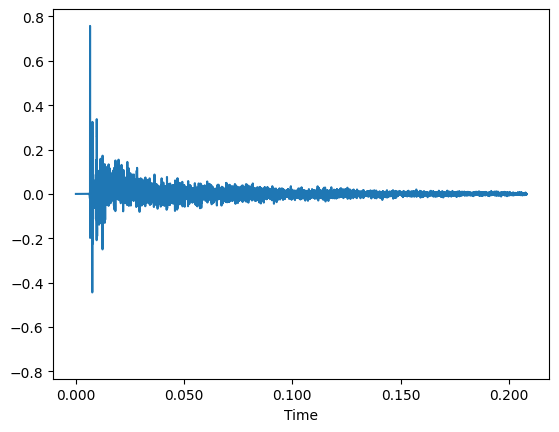

In [9]:
# plot the waveform of IR and show the audio
from librosa.display import waveshow, specshow
import IPython

waveshow(ir[0, :10000], sr=48000)
IPython.display.Audio(ir, rate=48000)

In [10]:
# one example for how to use IR data to get the reverberant speech
sr, vocal = wavfile.read('res/singing.wav')
print(sr, vocal.shape)
IPython.display.Audio(vocal, rate=sr)

48000 (233873,)


/tmp/ipykernel_27922/3675352108.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, vocal = wavfile.read('res/singing.wav')


In [11]:
from scipy.signal import fftconvolve

# convolve the vocal with IR
convolved_vocal = np.array([fftconvolve(vocal, ir_channel) for ir_channel in ir]) 
IPython.display.Audio(convolved_vocal, rate=sr)

In [ ]:
from pyroomacoustics.experimental.rt60 import measure_rt60

rt60 = measure_rt60(ir[0], sr, decay_db=30, plot=True)
print(f'RT60 of the rendered IR is {rt60:.4f} seconds')